# **WildFire Cause Prediction**

In [ ]:
#importing necessary libraries
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn import tree, preprocessing
from sklearn.metrics import accuracy_score, plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay,f1_score,precision_score,recall_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import sklearn.ensemble as ske

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/MyDrive/ALDA_Project'

/content/drive/MyDrive/ALDA_Project


In [ ]:
# reading from sqlite database 
from sqlalchemy import create_engine
my_conn=create_engine("sqlite:////content/drive/MyDrive/ALDA_Project/FPA_FOD_20170508.sqlite")

In [ ]:
# Reading the sql file 
df = pd.read_sql_query("SELECT FOD_ID, FIRE_YEAR, DISCOVERY_DATE, DISCOVERY_TIME, CONT_DATE, CONT_TIME, FIRE_SIZE, FIRE_SIZE_CLASS, LATITUDE, LONGITUDE, STATE, COUNTY, STAT_CAUSE_DESCR FROM Fires", my_conn)
df_original= df # a copy will be used later

NameError: ignored

In [ ]:
#converting the data to normal datatime format
df['START_DATE'] = pd.to_datetime(df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
df['END_DATE'] = pd.to_datetime(df['CONT_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
df.drop(['DISCOVERY_DATE', 'CONT_DATE'], axis=1, inplace=True)
df['MONTH'] = pd.DatetimeIndex(df['START_DATE']).month
# Reordering the columns
new_cols=['FOD_ID', 'FIRE_YEAR','MONTH','START_DATE','DISCOVERY_TIME', 'END_DATE','CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'STATE', 'COUNTY', 'STAT_CAUSE_DESCR']
df=df.reindex(columns=new_cols)
print(df.shape)
# First five rows
print(df.head())

,FOD_ID,FIRE_YEAR,MONTH,START_DATE,DISCOVERY_TIME,END_DATE,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,COUNTY,STAT_CAUSE_DESCR
0,1,2005,2,2005-02-02,1300,2005-02-02,1730,0.10,A,40.036944,-121.005833,CA,63,Miscellaneous
1,2,2004,5,2004-05-12,0845,2004-05-12,1530,0.25,A,38.933056,-120.404444,CA,61,Lightning
2,3,2004,5,2004-05-31,1921,2004-05-31,2024,0.10,A,38.984167,-120.735556,CA,17,Debris Burning
3,4,2004,6,2004-06-28,1600,2004-07-03,1400,0.10,A,38.559167,-119.913333,CA,3,Lightning
4,5,2004,6,2004-06-28,1600,2004-07-03,1200,0.10,A,38.559167,-119.933056,CA,3,Lightning


## EDA

In [ ]:
#check mising values and columns
q = df.columns[df.isnull().any()].tolist() 
print(q)

['DISCOVERY_TIME', 'END_DATE', 'CONT_TIME', 'COUNTY']

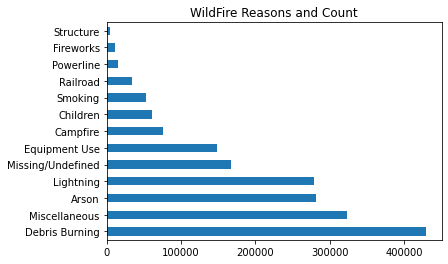

In [ ]:
# Number of Fires and different reasons
df['STAT_CAUSE_DESCR'].value_counts().plot(kind='barh')
plt.title('WildFire Reasons and Count')
plt.show()

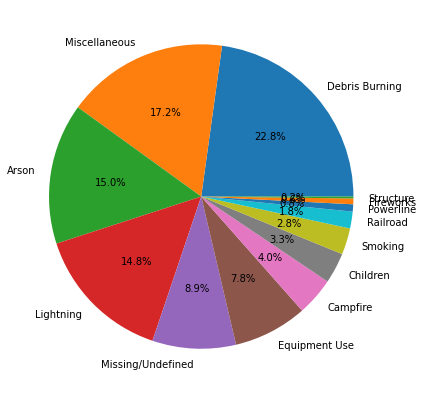

In [ ]:
# Wildfire cause and firecouny distribution
causes = df['STAT_CAUSE_DESCR'].value_counts()
fig = plt.figure(figsize =(10, 7))
plt.pie(causes, autopct='%1.1f%%',labels=causes.index)
plt.show()

Debris burning , Arson, Lightning are the major causes of wildfire accounting for more than 50% of total wildfires

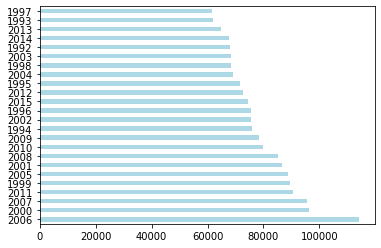

In [ ]:
#Yearwise firecount distribution
df['FIRE_YEAR'].value_counts().plot(kind='barh',color='lightblue')
plt.show()

There is no significant difference in year on year wildfire count

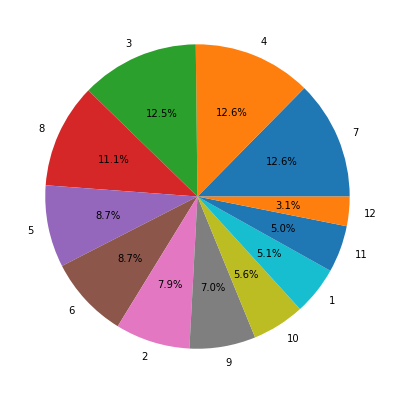

In [ ]:
# monthwise firecount distribution
months = df['MONTH'].value_counts()
fig = plt.figure(figsize =(10, 7))
plt.pie(months, autopct='%1.1f%%',labels=months.index)
plt.show()

There is significant difference between wildfire count from October-January and February-September. It might be because of weather, since weather is cold from October-January which is not conducive for wildfire. 

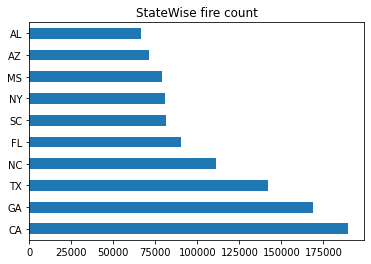

In [ ]:
# Plotting statewise firecount
df['STATE'].value_counts().head(n=10).plot(kind='barh')
plt.title('StateWise fire count')
plt.show()

In [ ]:
df_CA = df[df['STATE']=='CA']
df_GA = df[df['STATE']=='GA']
df_TX = df[df['STATE']=='TX']

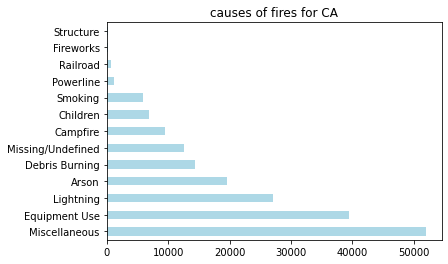

In [ ]:
# causes of fire in CA
df_CA['STAT_CAUSE_DESCR'].value_counts().plot(kind='barh',color='lightblue',title='causes of fires for CA')
plt.show()

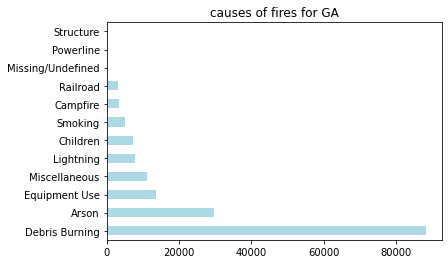

In [ ]:
# causes of fire in GA
df_GA['STAT_CAUSE_DESCR'].value_counts().plot(kind='barh',color='lightblue',title='causes of fires for GA')
plt.show()

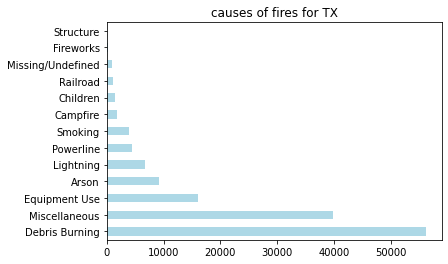

In [ ]:
# causes of fire in TX
df_TX['STAT_CAUSE_DESCR'].value_counts().plot(kind='barh',color='lightblue',title='causes of fires for TX')
plt.show()

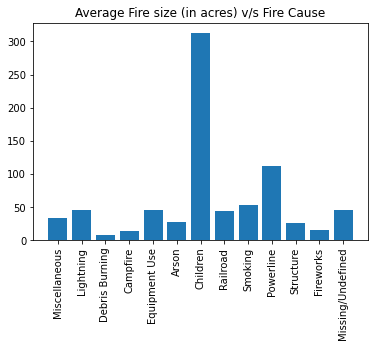

In [ ]:
# plotting firesize vs firecause
df1 = df.groupby('STAT_CAUSE_DESCR').mean()
plt.bar(df['STAT_CAUSE_DESCR'].unique(),df1['FIRE_SIZE'])
plt.xticks(rotation=90)
plt.title('Average Fire size (in acres) v/s Fire Cause')
plt.show()

Causes of fire vary state by state, so location will be critical attribute in prediction.

# Visualising the Dataset:


In [ ]:
#encoding the labels
le = preprocessing.LabelEncoder()
df['STAT_CAUSE_DESCR'] = le.fit_transform(df['STAT_CAUSE_DESCR'])
df['STATE'] = le.fit_transform(df['STATE'])
df.rename(columns = {"STAT_CAUSE_DESCR":"CAUSE"}, inplace="True")

In [ ]:
print(df.head())

,FOD_ID,FIRE_YEAR,MONTH,START_DATE,DISCOVERY_TIME,END_DATE,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,COUNTY,CAUSE
0,1,2005,2,2005-02-02,1300,2005-02-02,1730,0.10,A,40.036944,-121.005833,4,63,7
1,2,2004,5,2004-05-12,0845,2004-05-12,1530,0.25,A,38.933056,-120.404444,4,61,6
2,3,2004,5,2004-05-31,1921,2004-05-31,2024,0.10,A,38.984167,-120.735556,4,17,3
3,4,2004,6,2004-06-28,1600,2004-07-03,1400,0.10,A,38.559167,-119.913333,4,3,6
4,5,2004,6,2004-06-28,1600,2004-07-03,1200,0.10,A,38.559167,-119.933056,4,3,6


In [ ]:
df['DAY_OF_WEEK'] = pd.DatetimeIndex(df['START_DATE']).weekday

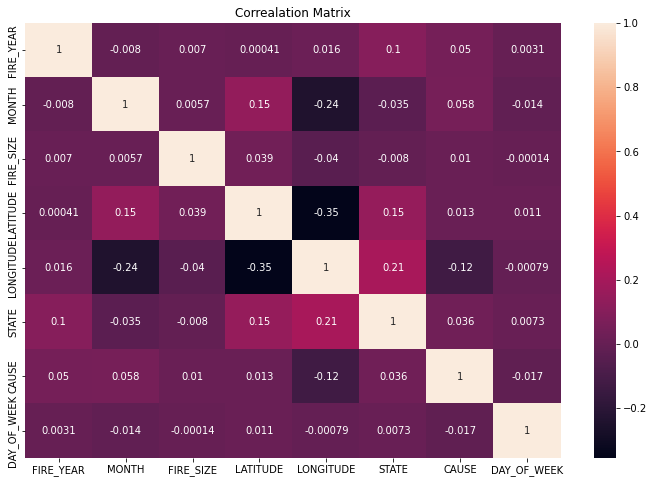

In [ ]:
#Corralation
plt.figure(figsize=(12, 8))
df_copy = df.drop('FOD_ID', axis=1)
corr = df_copy.corr()
sb.heatmap(corr, annot=True)
plt.title('Correalation Matrix')
plt.show()


In [ ]:
print(df.head())

,FOD_ID,FIRE_YEAR,MONTH,START_DATE,DISCOVERY_TIME,END_DATE,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,COUNTY,CAUSE,DAY_OF_WEEK
0,1,2005,2,2005-02-02,1300,2005-02-02,1730,0.10,A,40.036944,-121.005833,4,63,7,2
1,2,2004,5,2004-05-12,0845,2004-05-12,1530,0.25,A,38.933056,-120.404444,4,61,6,2
2,3,2004,5,2004-05-31,1921,2004-05-31,2024,0.10,A,38.984167,-120.735556,4,17,3,0
3,4,2004,6,2004-06-28,1600,2004-07-03,1400,0.10,A,38.559167,-119.913333,4,3,6,0
4,5,2004,6,2004-06-28,1600,2004-07-03,1200,0.10,A,38.559167,-119.933056,4,3,6,0


In [ ]:
xdf = df.drop(['FOD_ID','START_DATE','DISCOVERY_TIME','END_DATE','CONT_TIME','FIRE_SIZE_CLASS','COUNTY','CAUSE'], axis=1)
ydf = df['CAUSE']

X = df.drop(['FOD_ID','START_DATE','DISCOVERY_TIME','END_DATE','CONT_TIME','FIRE_SIZE_CLASS','COUNTY','CAUSE'], axis=1).values
y = df['CAUSE'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0) 

In [ ]:
# RFC with 13 features in the cause
model1 = ske.RandomForestClassifier(n_estimators=50)
model1 = model1.fit(X_train, y_train)
print(model1.score(X_test,y_test))

In [ ]:
# making 4 categories from 13 features
def set_label(cat):
    cause = 0
    natural = ['Lightning']
    accidental = ['Structure','Fireworks','Powerline','Railroad','Smoking','Children','Campfire','Equipment Use','Debris Burning']
    malicious = ['Arson']
    other = ['Missing/Undefined','Miscellaneous']
    if cat in natural:
        cause = 1
    elif cat in accidental:
        cause = 2
    elif cat in malicious:
        cause = 3
    else:
        cause = 4
    return cause
     

df['LABEL'] = df_original['STAT_CAUSE_DESCR'].apply(lambda x: set_label(x)) # I created a copy of the original df earlier in the kernel
df = df.drop('CAUSE',axis=1)
print(df.head())

,FOD_ID,FIRE_YEAR,MONTH,START_DATE,DISCOVERY_TIME,END_DATE,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,COUNTY,DAY_OF_WEEK,LABEL
0,1,2005,2,2005-02-02,1300,2005-02-02,1730,0.10,A,40.036944,-121.005833,4,63,2,4
1,2,2004,5,2004-05-12,0845,2004-05-12,1530,0.25,A,38.933056,-120.404444,4,61,2,1
2,3,2004,5,2004-05-31,1921,2004-05-31,2024,0.10,A,38.984167,-120.735556,4,17,0,2
3,4,2004,6,2004-06-28,1600,2004-07-03,1400,0.10,A,38.559167,-119.913333,4,3,0,1
4,5,2004,6,2004-06-28,1600,2004-07-03,1200,0.10,A,38.559167,-119.933056,4,3,0,1


In [ ]:
w = df['LABEL'].value_counts()
print(w)

2    830014
4    490528
3    281455
1    278468
Name: LABEL, dtype: int64

In [ ]:
X = df.drop(['FOD_ID','START_DATE','DISCOVERY_TIME','END_DATE','CONT_TIME','FIRE_SIZE_CLASS','COUNTY','LABEL'], axis=1).values
y = df['LABEL'].values
print(set(y))

{1, 2, 3, 4}


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)

# General Methods

## Random Forest Classifier

In [ ]:
# Random Forest Classifier
model2 = ske.RandomForestClassifier(n_estimators=50)
y_pred = model2.fit(X_train, y_train).predict(X_test)
#print(confusion_matrix(y_true=y_test,y_pred=y_pred))
print(classification_report(y_test, y_pred))
cm_rfc = confusion_matrix(y_test,y_pred,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rfc,display_labels=['natural','accidental','malicious','other'])
disp.plot()

[[ 66578  11329    904   4505]
 [ 11203 199452  16986  21687]
 [  1567  36114  38876   7613]
 [  7038  46365   5222  88701]]
              precision    recall  f1-score   support

           1       0.77      0.80      0.78     83316
           2       0.68      0.80      0.74    249328
           3       0.63      0.46      0.53     84170
           4       0.72      0.60      0.66    147326

    accuracy                           0.70    564140
   macro avg       0.70      0.67      0.68    564140
weighted avg       0.70      0.70      0.69    564140



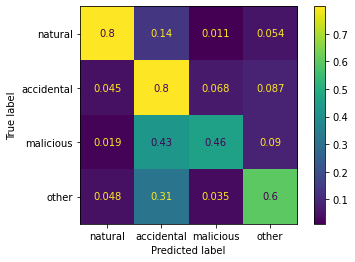

## Adaboost Classifier

              precision    recall  f1-score   support

           1       0.59      0.67      0.63     83316
           2       0.53      0.85      0.65    249328
           3       0.47      0.10      0.17     84170
           4       0.59      0.23      0.33    147326

    accuracy                           0.55    564140
   macro avg       0.55      0.46      0.45    564140
weighted avg       0.55      0.55      0.49    564140



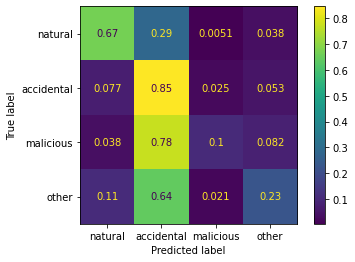

In [ ]:
#Adaboost classifier

from sklearn.ensemble import AdaBoostClassifier

clfab = AdaBoostClassifier(n_estimators=100, random_state=0)
clfab.fit(X_train, y_train)
y_pred_ab = clfab.predict(X_test)
print(classification_report(y_test, y_pred_ab))

cm_ab = confusion_matrix(y_test,y_pred_ab,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ab,display_labels=['natural','accidental','malicious','other'])
disp.plot()


## Decision Tree Classifier

              precision    recall  f1-score   support

           1       0.70      0.70      0.70     83316
           2       0.66      0.64      0.65    249328
           3       0.46      0.48      0.47     84170
           4       0.59      0.60      0.59    147326

    accuracy                           0.61    564140
   macro avg       0.60      0.60      0.60    564140
weighted avg       0.62      0.61      0.61    564140



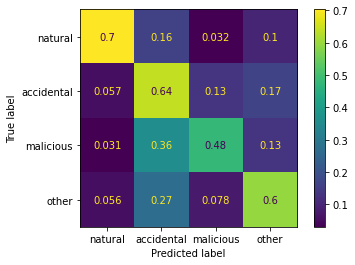

In [ ]:
#Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
clfdt = DecisionTreeClassifier(random_state=0)
clfdt.fit(X_train, y_train)
y_pred_dt = clfdt.predict(X_test)
print(classification_report(y_test, y_pred_dt))

cm_dt = confusion_matrix(y_test,y_pred_dt,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dt,display_labels=['natural','accidental','malicious','other'])
disp.plot()


## K Nearest Neighbor Classifier

In [ ]:
# K Nearest Neighbor Classifier
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print(classification_report(y_test, y_pred_knn))
cm_knn = confusion_matrix(y_test,y_pred_knn,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn,display_labels=['natural','accidental','malicious','other'])
disp.plot()

              precision    recall  f1-score   support

           1       0.67      0.77      0.72     83316
           2       0.64      0.74      0.69    249328
           3       0.49      0.37      0.42     84170
           4       0.68      0.54      0.60    147326

    accuracy                           0.64    564140
   macro avg       0.62      0.61      0.61    564140
weighted avg       0.63      0.64      0.63    564140



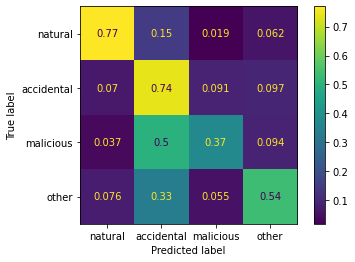

# Bi-Directional LSTM

In [ ]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Dropout, Conv1D, MaxPooling1D
import keras.utils
from keras.utils.np_utils import to_categorical
from keras.layers import LSTM

In [ ]:
# redefining training and testing set
xdf = df.drop(['FOD_ID','START_DATE','DISCOVERY_TIME','END_DATE','CONT_TIME','FIRE_SIZE_CLASS','COUNTY','LABEL'], axis=1)
ydf = df['LABEL']

print("Shape of x dataframe",xdf.shape)
print("Shape of y dataframe",ydf.shape)

(1880465, 7)
(1880465,)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(xdf,ydf,test_size=0.3,train_size=0.7)

print("X_train, Y_train shape",x_train.shape, y_train.shape)
print("\nX_test, Y_test shape",x_test.shape, y_test.shape)

X_train, Y_train shape (1316325, 7) (1316325,)

X_test, Y_test shape (564140, 7) (564140,)


In [ ]:
# Using Minmax scaler
from sklearn.preprocessing import StandardScaler,MinMaxScaler

scaler = MinMaxScaler()    # robust to outliers

scaler_train = scaler.fit(x_train)
scaler_val = scaler.fit(x_test)

x_train.loc[:] = scaler_train.transform(x_train.to_numpy())
x_test.loc[:] = scaler_train.transform(x_test.to_numpy())

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [ ]:
# converting fro 2D data 3D data
from scipy.stats import mode

def create_dataset(x, y, timesteps, step):
  x_set = []
  y_set = []
  for i in range(0,len(x)-timesteps, step):
    data = x.iloc[i: (i + timesteps)].values
    labels = y.iloc[i: i + timesteps]
    x_set.append(data)
    y_set.append(mode(labels)[0][0])
  
  return np.array(x_set), np.array(y_set).reshape(-1,1)

timesteps = 4
steps = 1

X_train, Y_train = create_dataset( x_train, y_train, timesteps, steps)        # making the dataset ready for training
X_test , Y_test = create_dataset( x_test, y_test, timesteps, steps)           # making the dataset ready for validation

In [ ]:
from tensorflow.keras.utils import to_categorical

print("Shape of x_train",X_train.shape)          
print("Shape of y_train",Y_train.shape)          

print("Shape of x_test",X_test.shape)           
print("shape of Y_test",Y_test.shape)           
print()

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)
print("Shpae of Y_train after categorical",Y_train.shape)          
print("Shape of Y_test after categorical",Y_test.shape)           

(1316321, 4, 7)
(1316321, 1)
(564136, 4, 7)
(564136, 1)

(1316321, 5)
(564136, 5)


In [ ]:
# parameters model building
batch_size = 128
epochs = 10

In [ ]:
# Builfing Bi-LSTM model
model = keras.Sequential()
model.add(keras.layers.Bidirectional(LSTM( units = 128, input_shape = [X_train.shape[1],X_train.shape[2]])))
model.add(Dropout(rate = 0.6))
model.add(Dense(units=128,activation='relu'))
model.add(Dense(units = 64,activation='relu'))
model.add(Dense(units=5,activation='softmax'))

model.compile(loss= 'categorical_crossentropy', optimizer = 'Adam', metrics = ['Accuracy'])


In [ ]:
# fitting the model
history = model.fit(X_train,Y_train, epochs = 1, batch_size = batch_size, validation_data= (X_test,Y_test))

10284/10284 [==============================] - 693s 67ms/step - loss: 0.8298 - Accuracy: 0.7249 - val_loss: 0.8151 - val_Accuracy: 0.7251


In [ ]:
# model prediction
print(model.summary(line_length= 80))
y_test_pred = model.predict(X_test)
p = np.argmax(y_test_pred,axis=1)
q = np.argmax(Y_test,axis=1)

In [ ]:
from sklearn.metrics import precision_score, f1_score, classification_report,recall_score,accuracy_score
prec = precision_score(q,p, average='weighted') # no warning
print("\nPrecision score :",prec)
f1 = f1_score(q,p, average='weighted')
print("\nF1_score \t:", f1)
recall = recall_score(q,p,average= 'micro')
print("\nRecall score    :",recall)
accuracy = accuracy_score(q,p)
print("\nAccuracy \t:",accuracy)
print()

# CNN

In [ ]:
#2D to 3D conversion
def create_dataset(x, y, timesteps, step):
  x_set = []
  y_set = []
  for i in range(0,len(x)-timesteps, step):
    data = x.iloc[i: (i + timesteps)].values
    labels = y.iloc[i: i + timesteps]
    x_set.append(data)
    y_set.append(mode(labels)[0][0])
  
  return np.array(x_set), np.array(y_set).reshape(-1,1)

In [ ]:
timesteps = 40
steps = 1
X_train, Y_train = create_dataset( x_train, y_train, timesteps, steps)
X_test , Y_test = create_dataset( x_test, y_test, timesteps, steps)

print("Shape of x_train",X_train.shape)          
print("Shape of y_train",Y_train.shape)          

print("Shape of x_test",X_test.shape)           
print("shape of Y_test",Y_test.shape)           
print()

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)
print("Shpae of Y_train after categorical",Y_train.shape)          
print("Shape of Y_test after categorical",Y_test.shape)  

(1316285, 40, 7)
(1316285, 1)
(564100, 40, 7)
(564100, 1)
(1316285, 5)
(564100, 5)


In [ ]:
# Building the model
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 conv1d (Conv1D)                    (None, 38, 128)                 2816        
                                                                                
 max_pooling1d (MaxPooling1D)       (None, 19, 128)                 0           
                                                                                
 conv1d_1 (Conv1D)                  (None, 17, 64)                  24640       
                                                                                
 dropout (Dropout)                  (None, 17, 64)                  0           
                                                                                
 max_pooling1d_1 (MaxPooling1D)     (None, 8, 64)                   0           
                                                                                
 flatten

In [ ]:
# fit network
history = model.fit(X_train, Y_train, validation_data=(X_test,Y_test), epochs=3, batch_size=128, verbose=1)
  

Epoch 1/3
10284/10284 [==============================] - 329s 32ms/step - loss: 0.2859 - accuracy: 0.9267 - val_loss: 0.2888 - val_accuracy: 0.9238
Epoch 2/3
10284/10284 [==============================] - 327s 32ms/step - loss: 0.2785 - accuracy: 0.9268 - val_loss: 0.2859 - val_accuracy: 0.9238
Epoch 3/3
10284/10284 [==============================] - 328s 32ms/step - loss: 0.2760 - accuracy: 0.9268 - val_loss: 0.2863 - val_accuracy: 0.9238


In [ ]:
# model prediction
print(model.summary(line_length= 80))
y_test_pred = model.predict(X_test)
p = np.argmax(y_test_pred,axis=1)
q = np.argmax(Y_test,axis=1)

In [ ]:
from sklearn.metrics import precision_score, f1_score, classification_report,recall_score,accuracy_score
prec = precision_score(q,p, average='weighted') # no warning
print("\nPrecision score :",prec)
f1 = f1_score(q,p, average='weighted')
print("\nF1_score \t:", f1)
recall = recall_score(q,p,average= 'micro')
print("\nRecall score    :",recall)
accuracy = accuracy_score(q,p)
print("\nAccuracy \t:",accuracy)
print()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Precision score : 0.8533717876164396

F1_score 	: 0.8871817313676837

Recall score    : 0.923781244460202

Accuracy 	: 0.923781244460202

